# Data Preparation
this notebook is used to reformat and extract data from the original datasets of macrizoobenthos and the environmental data.
### Start with environmental data

In [1]:
# Load libraries
import numpy as np
import pandas as pd

In [2]:
# macrozoobenthos data and environmental data (ices3)
ices3 = pd.read_csv('data/ices_data3.csv', header=18) # environmental data

# Select columns in environmental data
cols = ['yyyy-mm-ddThh:mm:ss.sss',
       'Latitude [degrees_north]', 'Longitude [degrees_east]',
       'Bot. Depth [m]', 'Secchi Depth [m]',
       'Depth (ADEPZZ01_ULAA) [m]',
       'Temperature (TEMPPR01_UPAA) [degC]',
       'Salinity (PSALPR01_UUUU) [dmnless]', 
       'Oxygen (DOXYZZXX_UMLL) [ml/l]',
       'Phosphate (PHOSZZXX_UPOX) [umol/l]',
       'Total Phosphorus (TPHSZZXX_UPOX) [umol/l]',
       'Silicate (SLCAZZXX_UPOX) [umol/l]',
       'Nitrate + Nitrite (NTRZZZXX_UPOX) [umol/l]',
       'Nitrate (NTRAZZXX_UPOX) [umol/l]', 
       'Nitrite (NTRIZZXX_UPOX) [umol/l]',
       'Ammonium (AMONZZXX_UPOX) [umol/l]', 
       'Total Nitrogen (NTOTZZXX_UPOX) [umol/l]',
       'Hydrogen SulphIDe (H2SXZZXX_UPOX) [umol/l]',
       'pH (PHXXZZXX_UUPH) [pH units]',
       'Total Alkalinity (ALKYZZXX_MEQL) [mEq/l]',
       'Chlorophyll a (CPHLZZXX_UGPL) [ug/l]']
ices3 = ices3[cols]


# Extract year-month-day from the datetime column
ices3['yyyy-mm-ddThh:mm:ss.sss'] = ices3['yyyy-mm-ddThh:mm:ss.sss'].astype(str)
ices3['yyyy-mm-ddThh:mm:ss.sss'].str.split(' ', expand=True)[0].str.split('T', expand=True)[0]
ices3['yyyy-mm-dd'] = pd.to_datetime(ices3['yyyy-mm-ddThh:mm:ss.sss'].str.split(' ', expand=True)[0].str.split('T', expand=True)[0])

# Aggregate the environmental data to yearly
ices3['year'] = ices3['yyyy-mm-dd'].dt.year
ices3 = ices3.drop(['yyyy-mm-ddThh:mm:ss.sss'], axis=1)
ices3.sort_values(by='yyyy-mm-dd', inplace=True)

# We see that there's a big number of missing data. I think we will forward fill and backward fill the data in time
ices3.isna().sum() / ices3.shape[0] 

# Round up the latitude and longitude to 2 decimal places
ices3['Latitude [degrees_north]'] = ices3['Latitude [degrees_north]'].round(2)
ices3['Longitude [degrees_east]'] = ices3['Longitude [degrees_east]'].round(2)

C:\Users\ttran\AppData\Local\Temp\ipykernel_19108\524319300.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ices3 = pd.read_csv('data/ices_data3.csv', header=18) # environmental data


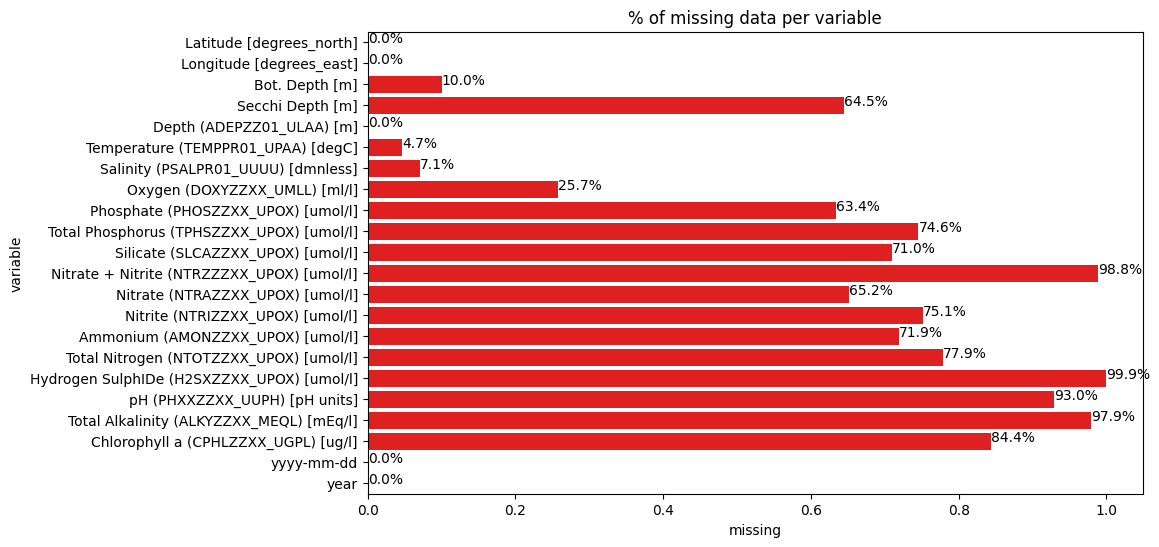

In [3]:
# Barplot for missing data per variable
import matplotlib.pyplot as plt
import seaborn as sns
missing = ices3.isna().sum() / ices3.shape[0]
missing = missing.reset_index()
missing.columns = ['variable', 'missing']
plt.figure(figsize=(10, 6))
sns.barplot(x='missing', y='variable', data=missing, color='red')
# Add text showing the percentage
for i in range(missing.shape[0]):
    plt.text(missing['missing'][i], i, '{:.1f}%'.format(missing['missing'][i]*100))
plt.title("% of missing data per variable")
plt.show()

In [4]:
# missing variables
missing_vars = ['Bot. Depth [m]', 'Secchi Depth [m]', 'Depth (ADEPZZ01_ULAA) [m]',
       'Temperature (TEMPPR01_UPAA) [degC]',
       'Salinity (PSALPR01_UUUU) [dmnless]', 'Oxygen (DOXYZZXX_UMLL) [ml/l]',
       'Phosphate (PHOSZZXX_UPOX) [umol/l]',
       'Total Phosphorus (TPHSZZXX_UPOX) [umol/l]',
       'Silicate (SLCAZZXX_UPOX) [umol/l]',
       'Nitrate + Nitrite (NTRZZZXX_UPOX) [umol/l]',
       'Nitrate (NTRAZZXX_UPOX) [umol/l]', 'Nitrite (NTRIZZXX_UPOX) [umol/l]',
       'Ammonium (AMONZZXX_UPOX) [umol/l]',
       'Total Nitrogen (NTOTZZXX_UPOX) [umol/l]',
       'Hydrogen SulphIDe (H2SXZZXX_UPOX) [umol/l]',
       'pH (PHXXZZXX_UUPH) [pH units]',
       'Total Alkalinity (ALKYZZXX_MEQL) [mEq/l]',
       'Chlorophyll a (CPHLZZXX_UGPL) [ug/l]']

# Fill in missing values
ices3[missing_vars] = ices3.groupby(['Latitude [degrees_north]', 'Longitude [degrees_east]'])[missing_vars].ffill().bfill()

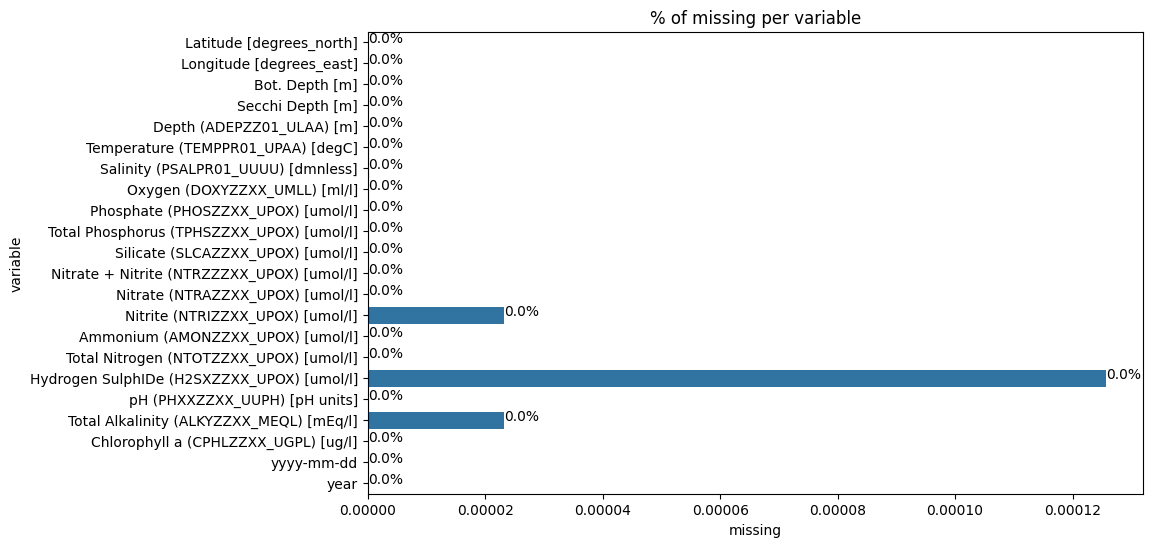

In [5]:
# Barplot for missing data per variable
missing = ices3.isna().sum() / ices3.shape[0]
missing = missing.reset_index()
missing.columns = ['variable', 'missing']
plt.figure(figsize=(10, 6))
sns.barplot(x='missing', y='variable', data=missing)

# Add text showing the percentage
for i in range(missing.shape[0]):
    plt.text(missing['missing'][i], i, '{:.1f}%'.format(missing['missing'][i]*100))
plt.title("% of missing per variable")
plt.show()

In [6]:
ices3.drop('yyyy-mm-dd', axis=1, inplace=True) # drop the datetime column

# Drop the remaining missing data
ices3.dropna(inplace=True)

# Group by location, year and aggregate the data
ices3 = ices3.groupby(['Latitude [degrees_north]', 'Longitude [degrees_east]', 'year']).mean().reset_index()

# Rename the columns
rename_cols = {'Latitude [degrees_north]': 'latitude', 
               'Longitude [degrees_east]': 'longitude',
                'Bot. Depth [m]' : 'bot_depth', 
                'Secchi Depth [m]' : 'secchi_depth', 
                'Depth (ADEPZZ01_ULAA) [m]' : 'depth',
                'Temperature (TEMPPR01_UPAA) [degC]' : 'temperature',
                'Salinity (PSALPR01_UUUU) [dmnless]' : 'salinity', 
                'Oxygen (DOXYZZXX_UMLL) [ml/l]' : 'oxygen',
                'Phosphate (PHOSZZXX_UPOX) [umol/l]' : 'phosphate',
                'Total Phosphorus (TPHSZZXX_UPOX) [umol/l]' : 'total_phosphorus',
                'Silicate (SLCAZZXX_UPOX) [umol/l]' : 'silicate',
                'Nitrate + Nitrite (NTRZZZXX_UPOX) [umol/l]' : 'nitrate_nitrite',
                'Nitrate (NTRAZZXX_UPOX) [umol/l]' : 'nitrate', 
                'Nitrite (NTRIZZXX_UPOX) [umol/l]' : 'nitrite',
                'Ammonium (AMONZZXX_UPOX) [umol/l]' : 'ammonium',
                'Total Nitrogen (NTOTZZXX_UPOX) [umol/l]' : 'total_nitrogen',
                'Hydrogen SulphIDe (H2SXZZXX_UPOX) [umol/l]' : 'hydrogen_sulphide',
                'pH (PHXXZZXX_UUPH) [pH units]' : 'ph',
                'Total Alkalinity (ALKYZZXX_MEQL) [mEq/l]' : 'total_alkalinity',
                'Chlorophyll a (CPHLZZXX_UGPL) [ug/l]' : 'chlorophyll_a'}

ices3.rename(columns=rename_cols, inplace=True)
ices3['site'] = 'site' + '_' + ices3['latitude'].astype(str) + '_' + ices3['longitude'].astype(str)

In [7]:
# Export data
ices3.to_csv('data/ices_data3_cleaned.csv', index=False)

# Zoobenthos Data


In [8]:
rawdf = pd.read_csv('data/raw_data_macrozoobenthos_1980-2005.csv', header=0) # original dataset

# Extract relevant columns to create Site by Abundance matrix
data = rawdf[['scientificnameaccepted', \
    'decimallatitude', 'decimallongitude', \
    'yearcollected',  'monthcollected', 'daycollected', \
     'minimumdepthinmeters', 'maximumdepthinmeters', 'Count (Dmnless)'
    ]]

# Create variable Site using latitude and longitude
data['site'] = 'site_' + data['decimallatitude'].astype(str) + '_' + data['decimallongitude'].astype(str)
data = data[['site', 'scientificnameaccepted', \
    'decimallatitude', 'decimallongitude', \
    'yearcollected',  'monthcollected', 'daycollected', \
     'minimumdepthinmeters', 'maximumdepthinmeters', 'Count (Dmnless)'
    ]]

# Filter data to only include data from 19894 to 2004
# data = data[(data['yearcollected'] >= 1984) & (data['yearcollected'] <= 2004)]

# Drop month and day columns
data.drop(['monthcollected', 'daycollected'], axis=1, inplace=True)
# Group data by site and year

data = data.groupby(['site', 'yearcollected', 'scientificnameaccepted']).sum().reset_index()
data.rename(columns={'Count (Dmnless)': 'abundance',
                     'yearcollected': 'year',
                     'scientificnameaccepted': 'species',
                    'decimallatitude': 'latitude',
                    'decimallongitude': 'longitude',
                    'minimumdepthinmeters': 'min_depth',
                    'maximumdepthinmeters': 'max_depth'
                     }, inplace=True)

data['latitude'] = data['site'].str.split('_', expand=True)[1].astype(float)
data['longitude'] = data['site'].str.split('_', expand=True)[2].astype(float)


C:\Users\ttran\AppData\Local\Temp\ipykernel_19108\416332103.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['site'] = 'site_' + data['decimallatitude'].astype(str) + '_' + data['decimallongitude'].astype(str)


# Do we have environmental data for every site at every time point?

### Do we have environmental data for every site?

In [ ]:
# Do we have zoobenthos data for the same sites for at least more than 5 years?
sites = data.groupby(['site'])['year'].nunique()    
# print(sites)

# Filter sites with data for at least 15 years
sites = sites[sites >= 15].index
data = data[data['site'].isin(sites)]

sites = data.groupby(['site'])['year'].nunique()    
print(sites)

site
site_54.32_11.55    19
site_54.63_14.28    15
site_54.73_12.79    23
site_55.0_14.08     20
Name: year, dtype: int64


In [10]:
# Create a function to returns the closest site to a given site
def closest_site(site, sites):
    """
    Function to return the closest site to a given site
    """
    site = site.split('_')[1:]
    lat = float(site[0])
    lon = float(site[1])
    closet_site = None
    min_distance = 1000000
    for s in sites:
        s = s.split('_')[1:]
        lat_s = float(s[0])
        lon_s = float(s[1])
        distance = np.sqrt((lat - lat_s)**2 + (lon - lon_s)**2)
        if distance < min_distance:
            min_distance = distance
            closet_site = "site_" + str(lat_s) + "_" + str(lon_s)
    return closet_site


# =============================================================================
# Check if we can have the closet site for each site in the data
env_sites = ices3['site'].unique()
data_sites = data['site'].unique()
for s in data_sites:
    if s not in env_sites:
        closet_site = closest_site(s, env_sites)
        print("No information for site {}. Closest site is {}".format(s, closet_site))
    else:
        print("Information available for site {}".format(s))
        

Information available for site site_54.32_11.55
Information available for site site_54.63_14.28
Information available for site site_54.73_12.79
Information available for site site_55.0_14.08


All the sites chosen have environmental data.
Now let's see the total abundance of all the species at each site.

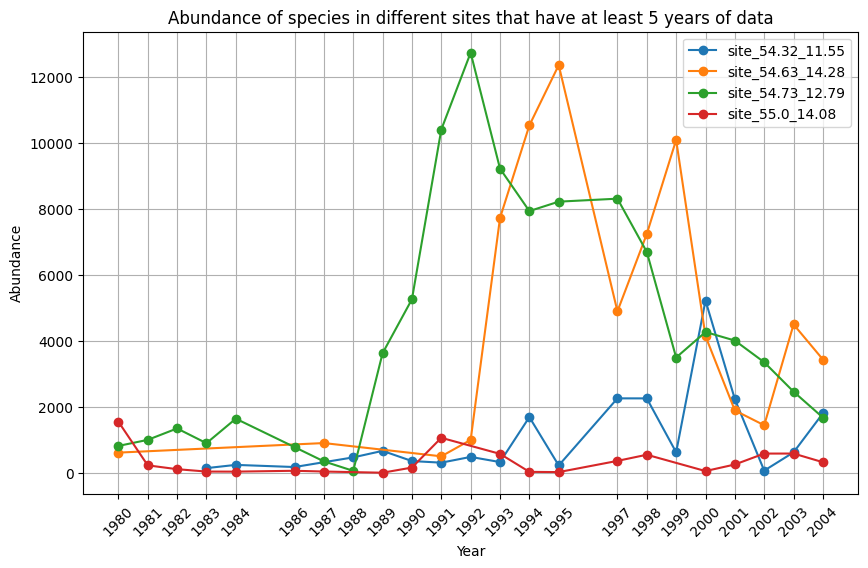

In [11]:
data_plot = data.groupby(['site', 'year'])['abundance'].sum().reset_index()
plt.figure(figsize=(10, 6))
for s in data['site'].unique():
    d = data_plot[data_plot['site'] == s]
    plt.plot(d['year'], d['abundance'], label=s, marker='o', linestyle='-')

plt.legend()
# Grid at every year
plt.grid()
plt.xlabel('Year')
plt.xticks(data_plot['year'].unique(), rotation=45)

plt.ylabel('Abundance')
plt.title('Abundance of species in different sites that have at least 5 years of data')
plt.show()

In [1]:
# # Now check the abundance of species in different sites over time again
# data_plot = data.groupby(['site', 'year'])['abundance'].sum().reset_index()
# plt.figure(figsize=(10, 6))
# for s in data['site'].unique():
#     d = data_plot[data_plot['site'] == s]
#     plt.plot(d['year'], d['abundance'], label=s, marker='o', linestyle='-')

# plt.legend()
# # Grid at every year
# plt.grid()
# plt.xlabel('Year')
# plt.xticks(data_plot['year'].unique(), rotation=45)

# plt.ylabel('Abundance')
# plt.title('Abundance of species in different sites that have at least 5 years of data')
# plt.show()

### Do we have environmental data for every time point for each site?

In [13]:
# Mapping the sites to its coordinates
mapping_sites = data['site'].unique()
mapping = {s : "S{}".format(i) for i, s in enumerate(mapping_sites)}
mapping

# Insert the mapping into the data
data['site_id'] = data['site'].map(mapping)
mapping

mapping_df = pd.DataFrame(mapping.items(), columns=['site', 'site_id'])
mapping_df.to_csv('data/site_mapping.csv', index=False)

In [14]:
# Check if we can have the closet site for each site in the data
env_sites = ices3['site'].unique()
data_sites = data['site'].unique()
nb_years = data['year'].unique().shape[0]

for s in data_sites:
    # print("Site: ", s)
    s_id = mapping[s]
    counter = 0
    for y in data['year'].unique():
        nb_year = len(data[data['site'] == s]['year'].unique())
        data_y = data[data['year'] == y]
        # print("Year: ", y)
        if s not in env_sites:
            closet_site_s = closest_site(s, env_sites)
            # Check if there is environmental data for the closest site at the same year
            if ices3[(ices3['site'] == closet_site_s) & (ices3['year'] == y)].shape[0] == 0:
                # print("NO env for {} (using closest site {}) in year {}".format(s_id, closet_site_s, y))
                pass
            else:
                counter += 1
                # print("env NO avail for site {} but AVAIL for closest site {} in year {}".format(s_id, closet_site_s, y))
        else:
            if ices3[(ices3['site'] == s) & (ices3['year'] == y)].shape[0] == 0:
                # print("NO envr for site {} in year {} ".format(s_id, y))
                pass
            else:
                counter += 1
                # print("env AVAIL for site {} in year {}".format(s_id, y))
    print("Number of years with envr information: {} / {} for site {}".format(counter , nb_year, s_id))
    print("-"*20 +"\n")
    
print("Mapping used: ", mapping)

Number of years with envr information: 21 / 19 for site S0
--------------------

Number of years with envr information: 13 / 15 for site S1
--------------------

Number of years with envr information: 2 / 23 for site S2
--------------------

Number of years with envr information: 23 / 20 for site S3
--------------------

Mapping used:  {'site_54.32_11.55': 'S0', 'site_54.63_14.28': 'S1', 'site_54.73_12.79': 'S2', 'site_55.0_14.08': 'S3'}


### Conclusions:
- **Abundance data**: We have abundance data for all the sites from 1984 to 2004. We will fill in the missing years by the average of the previous and next year.
- We chose 3 sites for the analysis 
  - 'site_54.32_11.55': 'S0',
  - 'site_54.63_14.28': 'S1', 
  - 'site_55.0_14.08': 'S3'
  for the abundanceanalysis.

- For temporal analysis, we will use the sites S0, S2, S3
  
### Next Steps:
- Create 2 datasets : data_abundance and data_temporal
- Fill in the missing years for abundance data for the sites 'S0', 'S1', 'S3'
- Fill in the missing years for environmental data for the site 'S0'

  


In [24]:

data_abundance = data[data.site_id.isin(["S0", "S1", "S3"])]
data_temporal = data[data.site_id.isin(["S0", "S2", "S3"])]
data_temporal = data_temporal[data_temporal['year'] >= 1984]

## Check the number of missing years in the data
def missing_year(data):
    """
    Function to check the number of missing years in the data
    """
    sites = data['site'].unique()
    years = data['year'].unique()
    missing = []
    for s in sites:
        y = data[data['site'] == s]['year'].unique()
        missing_years = [year for year in years if year not in y]
        if len(missing_years) > 0:
            missing.append((s, missing_years))
    return missing

missing = missing_year(data_temporal)
print("missing years: ", missing)


# Fill in missing years using previous year and next year of the same site and species
def fill_missing_year(site, year, data):
    prev = year - 1
    next_y = year + 1
    # if prev in data['year'].unique() and next_y in data['year'].unique():
    data_prev = data[(data['site'] == site) & (data['year'] == prev)]
    data_next = data[(data['site'] == site) & (data['year'] == next_y)]
    
    if data_prev.shape[0] > 0 and data_next.shape[0] > 0:
        # Find all the species in the previous year/next year
        species_prev = data_prev['species'].unique()
        species_next = data_next['species'].unique()
        abundances = {}
        for s in species_prev:
            if s not in abundances:
                abundances[s] = data_prev[data_prev['species'] == s]['abundance'].values[0]
            else:
                abundances[s] += data_prev[data_prev['species'] == s]['abundance'].values[0]
        for s in species_next:
            if s not in abundances:
                abundances[s] = data_next[data_next['species'] == s]['abundance'].values[0]
            else:
                abundances[s] += data_next[data_next['species'] == s]['abundance'].values[0]
        # Take the average of the two years
        abundances = {k: v/2 for k, v in abundances.items()}
        
        # Create a new dataframe
        data_new = pd.DataFrame(abundances.items(), columns=['species', 'abundance'])
        data_new['site'] = site
        data_new['site_id'] = data_prev['site_id'].values[0]
        data_new['year'] = year
        data_new['latitude'] = data_prev['latitude'].values[0]
        data_new['longitude'] = data_prev['longitude'].values[0]
        data_new['min_depth'] = (data_prev['min_depth'].values[0] + data_next['min_depth'].values[0]) / 2
        data_new['max_depth'] = (data_prev['max_depth'].values[0] + data_next['max_depth'].values[0]) / 2
        
        # Concatenate data_new back to the original data
        data = pd.concat([data, data_new])

        return data


# Fill in missing years
for m in missing:
    site = m[0]
    years = m[1]
    for y in years:
        data_temporal = fill_missing_year(site, y, data_temporal)
    

# # Also fill in for all sites the year 1996
for s in data_temporal['site'].unique():
    data_temporal = fill_missing_year(s, 1996, data_temporal)
# Also fill in for all sites the year 1985
for s in data_temporal['site'].unique():
    data_temporal = fill_missing_year(s, 1985, data_temporal)   


missing years:  [('site_54.32_11.55', [np.int64(1987)]), ('site_55.0_14.08', [np.int64(1988), np.int64(1992), np.int64(1999)])]


In [25]:
data_temporal = data_temporal.sort_values(by=['site_id', 'year'])
data_temporal.to_csv('data/data_temporal.csv', index=False)

In [17]:

ices3["site_id"] = ices3['site'].map(mapping)
ices3.dropna(inplace=True)
# Create a dataframe for 1989 and 1990 for environmental data using forward fill and backward fill
env_1989 = {"latitude": [54.32], "longitude": [11.55], "year": [1989], "site_id": ["S0"], "site" : ["site_54.32_11.55"]}
env_1990 = {"latitude": [54.32], "longitude": [11.55], "year": [1990], "site_id": ["S0"], "site" : ["site_54.32_11.55"]}
# env_1990 = {"latitude": [54.32], "longitude": [11.55], "year": [1990], "site_id": ["S0"]}
env_1989 = pd.DataFrame(env_1989)
env_1990 = pd.DataFrame(env_1990)
ices3 = pd.concat([ices3, env_1989, env_1990])

ices3[ices3['site_id'] == 'S0'].sort_values(by=['site_id','year'])
# Reset index
ices3.reset_index(drop=True, inplace=True)

# Group by site and forwar fill and backward fill the data
cols = ['bot_depth', 'secchi_depth', 'depth', 'temperature', 'salinity', 'oxygen', 'phosphate', 'total_phosphorus', 'silicate',
       'nitrate_nitrite', 'nitrate', 'nitrite', 'ammonium', 'total_nitrogen', 'hydrogen_sulphide', 'ph', 'total_alkalinity', 'chlorophyll_a']
ices3[cols] = ices3.groupby(['site_id'])[cols].ffill()

In [18]:
# ices3.fillna(method='ffill').sort_values(by=['year'])  
ices3 = ices3[ices3['site_id'].isin(["S0", "S1", "S3"])]

# Check the number of years unique for each site_id
sites = ices3.groupby(['site_id'])['year'].nunique()
print("Number of unique years for each site: ", sites)

Number of unique years for each site:  site_id
S0    26
S1    16
S3    26
Name: year, dtype: int64


Let's fill in the missing years in the 

### Merge data and env data

In [19]:
# Merge the data
df = pd.merge(data_abundance[data_abundance["site_id"].isin(["S0", "S1", "S3"])], ices3, how='left', on=['site_id', 'year', "site", "latitude", "longitude"])
# df
# Expore data
df.to_csv('data/data_abundance.csv', index=False)


# Create site by species data per year


From the given data_abundance dataframe, create a new data_frame that turn each site + year into a specific site

In [20]:
sbys_prev = df.copy()
sbys_prev['site_year'] = sbys_prev['site_id'] + "_" + sbys_prev['year'].astype(str)
sbys_prev
sbys = sbys_prev.pivot_table(index='site_year', columns='species', values='abundance').fillna(0)

sbys = sbys.reset_index()
sbys
sbys.to_csv('data/sbys_s013.csv', index=False)

In [21]:
# # Extract also the coordinantes of each site
df['site_year'] = df['site_id'] + "_" + df['year'].astype(str)
site_coords = df[['site_year', 'latitude', 'longitude']].drop_duplicates()
site_coords.set_index('site_year', inplace=True)
site_coords


# Extract environmental data
env_data = df.drop(['latitude', 'longitude', 'species', 'abundance', 'site', 'year', 'site_id'], axis=1).drop_duplicates()
env_data.dropna(inplace=True)
env_data.reset_index(drop=True, inplace=True)
# Group by site_id 
env_data = env_data.groupby(['site_year']).mean().reset_index()
env_data
# env_data = env_data.drop(env_data.index[7])  # drops the row
# env_data = env_data.drop(env_data.index[4])  # drops the row
env_data.to_csv('data/env_data.csv', index=False)

# Prep for temporal data analysis

In [26]:
# For each site, create time by species matrix
S0 = data_temporal[data_temporal['site_id'] == 'S0']
S3 = data_temporal[data_temporal['site_id'] == 'S3']
S2 = data_temporal[data_temporal['site_id'] == 'S2']


# Pivot the data
S0 = S0.pivot_table(index='year', columns='species', values='abundance').fillna(0)
S3 = S3.pivot_table(index='year', columns='species', values='abundance').fillna(0)
S2 = S2.pivot_table(index='year', columns='species', values='abundance').fillna(0)

S0.to_csv('data/S0_tbs.csv', index=True)
S3.to_csv('data/S3_tbs.csv', index=True)
S2.to_csv('data/S2_tbs.csv', index=True)